In [ ]:
## imports
import matplotlib.pyplot as plt
import skimage.io as skio
import skimage
import numpy as np
import skimage.morphology as morpho
from skimage.feature import canny
from skimage import filters
from skimage import exposure
import matplotlib.pyplot as plt
from skimage import color, io
import cv2
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

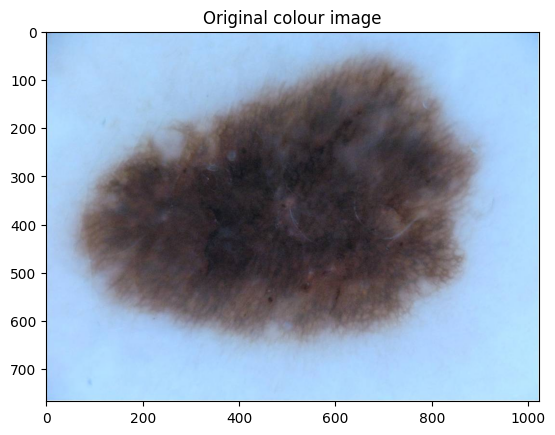

In [ ]:
# Load images
img = skio.imread("ISIC_0000000.jpg",as_gray=True)*255 # grayscale image
result = skio.imread("ISIC_0000000_Segmentation.png",as_gray=True) # segmentation
(m,n) = np.shape(img)

# Show the original colour image
plt.figure()
plt.imshow(skio.imread("/content/ISIC_0000000.jpg"))
plt.title('Original colour image')


## choose the method of segmentation
method_0 = 1
method_1 = 0
method_2 = 0


Text(0.5, 1.0, 'Hair removed')

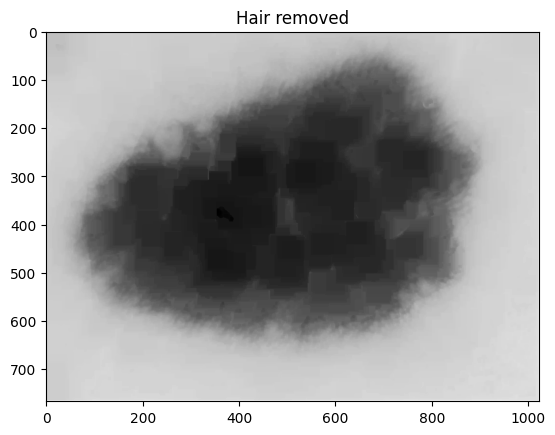

In [ ]:
# Hair removal

# Histogram equalization to improve contrast
img_eq = exposure.equalize_hist(img)

# Closing the image - to be used for hair removal
strell2 = morpho.disk(20)
strell0 = morpho.square(38)
img_clo = morpho.closing(img,strell0)

## Hair detection - top-hats with different structuring elements

# structuring elements
strel_ver = np.ones((25,1)) # vertical line
strel_hor = np.ones((2,5)) # horizontal line
strel_diag1 = np.eye(25) # diagonal line

# apply top-hats
img_ver = img_eq - morpho.closing(img_eq,strel_ver)
img_hor = img_eq - morpho.closing(img_eq,strel_hor)
img_diag1 = img_eq - morpho.closing(img_eq,strel_diag1)

# binarize images with an automatic threshold
img_ver_b = img_ver < filters.threshold_otsu(img_ver, 256)
img_hor_b = img_hor < filters.threshold_otsu(img_hor, 256)
img_diag1_b = img_diag1 < filters.threshold_otsu(img_diag1, 256)

# final top-hat image
img_tophat = img_ver_b + img_hor_b + img_diag1_b

# Dilatation of the detected edges for better hair localization
img_edge_dl = morpho.dilation(img_tophat,morpho.disk(5))

# Removal of hair - replace the hair pixels with closed image values
img_rem = img
img_rem[img_edge_dl] = img_clo[img_edge_dl]


# Closing of the image to improve the obtained results
img_rem_clo = morpho.closing(img_rem,morpho.square(5))

## plot the final result of hair removal and the original photo
plt.imshow(img_rem_clo,cmap='gray')
plt.title('Hair removed')

In [ ]:
'''
Method working for all images - with contours
'''
if method_0:
  img_gray = img_clo

  # Thresholding to create a binary mask of the shape
  _i1, img_binary = cv2.threshold(img_gray, 128, 255, cv2.THRESH_BINARY)

  # Apply morphological operations to clean up the mask
  kernel_open = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
  kernel_close = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15))

  img_open = cv2.morphologyEx(img_binary, cv2.MORPH_OPEN, kernel_open)
  img_closed = cv2.morphologyEx(img_open, cv2.MORPH_CLOSE, kernel_close)

  # type CV_8UC1
  img_closed = cv2.convertScaleAbs(img_closed)

  # Find contours in the binary image
  contours, _ = cv2.findContours(img_closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  # Filtering contours based on area : removing small contours
  min_contour_area = 1000
  filtered_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > min_contour_area]

  # Create an empty mask
  mask = np.zeros_like(img_gray)

  # Draw the filtered contours on the mask
  cv2.drawContours(mask, filtered_contours, -1, 255, thickness=cv2.FILLED)

  # Type CV_8UC1
  mask = cv2.convertScaleAbs(mask)

  # # Bitwise AND operation to keep only the region inside the contours
  # result = cv2.bitwise_and(img, img, mask=mask)

  # Substurcting the the mask from the colsing
  final_result_out = img_closed - mask

  # Display Results
  fig, axes = plt.subplots(1, 4, figsize=(18, 5))

  axes[0].imshow(img,cmap='gray')
  axes[0].set_title('Original Image')

  axes[1].imshow(img_closed, cmap='gray')
  axes[1].set_title('Morphological Closing')

  axes[2].imshow(mask, cmap='gray')
  axes[2].set_title('Mask with Contours')

  axes[3].imshow(final_result_out, cmap='gray')
  axes[3].set_title('Result After Removing Exterior')

  plt.show()

In [ ]:
# Method 1 :
'''
Opening with disk of size 4
Closing with disk of size 10
Then morpholigical gradient with disk of size 10
'''

if method_1:
  # Morphological Opening
  _open = morpho.disk(4)
  img_open = morpho.opening(img, _open)

  # Morphological Closing
  _close = morpho.disk(10)
  img_closed = morpho.closing(img_open, _close)

  # Morphological Gradient
  morpho_grad = morpho.dilation(img_open, _close) - morpho.erosion(img_open, _close)

  # Display Results
  fig, axes = plt.subplots(1, 3, figsize=(15, 5))

  axes[0].imshow(img, cmap='gray')
  axes[0].set_title('Original Image')

  axes[1].imshow(img_open, cmap='gray')
  axes[1].set_title('Morphological Opening')

  axes[2].imshow(img_closed, cmap='gray')
  axes[2].set_title('Morphological Closing')

  plt.show()

  # Display Morphological Gradient
  plt.figure(figsize=(5, 5))
  plt.imshow(morpho_grad, cmap='gray')
  plt.title('Morphological Gradient')
  plt.show()

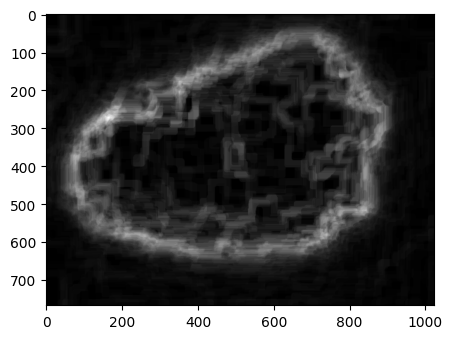

In [ ]:
'''
Method 2 :
Opening with disk of size 4
Then morpho with square of size 20
'''
if method_2:
  img = img_clo

  strell = morpho.disk(4)
  img_opn = morpho.opening(img, strell)

  strell = morpho.square(20)
  morpho_grad = morpho.dilation(img_opn, strell) - morpho.erosion(img_opn, strell)

  # img_open = morpho.closing(morpho_grad, strell)
  # img_open  = morpho.opening(img_open, strell)

  plt.figure(figsize=(5,5))
  plt.imshow(morpho_grad,cmap = "gray")
  plt.show()

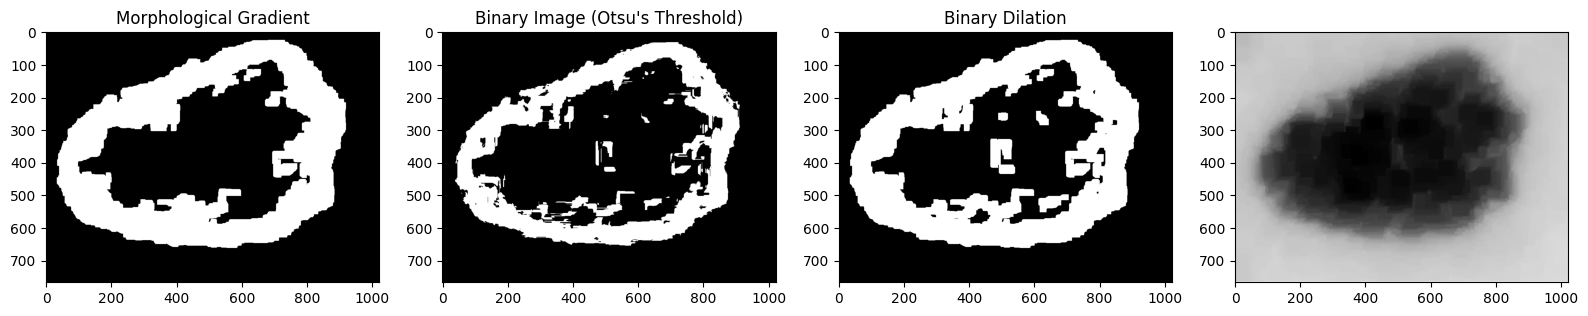

In [ ]:
'''
Thresholding with otsu method and then dilation
'''
# thresholding :
if method_1 or method_2:
  thresh = skimage.filters.threshold_otsu(morpho_grad)
  binary_img = morpho_grad > thresh

  # Binary Dilation
  strell_size = 15
  strell = morpho.square(strell_size)
  img_open = morpho.binary_dilation(binary_img, strell)


  # Removing small artifacts :

  img_result = skimage.morphology.area_closing(img_open, area_threshold=126000, connectivity=1, parent=None, tree_traverser=None)
  final_result_out = skimage.morphology.area_opening(img_result, area_threshold=56000, connectivity=1, parent=None, tree_traverser=None)

  # Display Results
  plt.figure(figsize=(16, 16))

  plt.subplot(1, 4, 1)
  plt.imshow(final_result_out, cmap="gray")
  plt.title('Morphological Gradient')

  plt.subplot(1, 4, 2)
  plt.imshow(binary_img, cmap="gray")
  plt.title("Binary Image (Otsu's Threshold)")

  plt.subplot(1, 4, 3)
  plt.imshow(img_open, cmap="gray")
  plt.title('Binary Dilation')



  plt.subplot(1,4, 4)
  plt.imshow(img, cmap= 'gray')
  plt.tight_layout()
  plt.show()

Text(0.5, 1.0, 'Our segmentation')

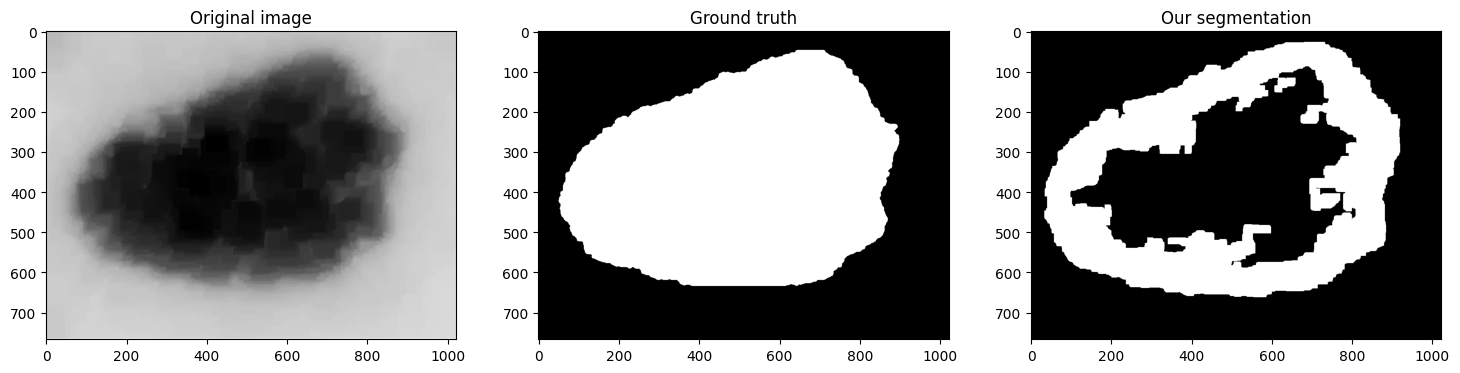

In [ ]:

fig,ax = plt.subplots(1, 3, figsize=(18,18))

ax[0].imshow(img, cmap = "gray")
ax[0].set_title('Original image')

ax[1].imshow(result, cmap = "gray")
ax[1].set_title('Ground truth')

ax[2].imshow(final_result_out, cmap = "gray")
ax[2].set_title('Our segmentation')

Text(0.5, 1.0, 'Ground truth')

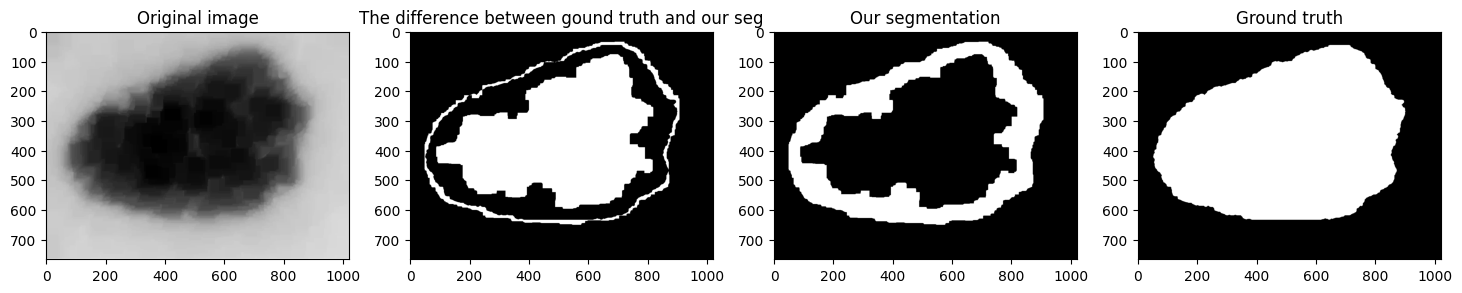

In [ ]:
# Final erosion

final_result = skimage.morphology.erosion(final_result_out, skimage.morphology.square(20))

# final opening
final_result = morpho.binary_opening(final_result, skimage.morphology.square(25))

fig,ax = plt.subplots(1,4, figsize=(18,18))
ax[0].imshow(img,cmap='gray')
ax[0].set_title("Original image")
ax[1].imshow(final_result != (result>150),cmap='gray')
ax[1].set_title("The difference between gound truth and our seg")
ax[2].imshow(final_result, cmap = "gray")
ax[2].set_title("Our segmentation")
ax[3].imshow(result, cmap = "gray")
ax[3].set_title("Ground truth")

In [ ]:
diff = 0
img_result = result>100 # the ground result
result_flat = final_result_out.flatten()
img_result_flat = img_result.flatten()
for i in range(len(img_result_flat)):
    if img_result_flat[i] != result_flat[i]:
        diff +=1
print("the percentage of the difference : ", diff* 100 / len(result_flat))

the percentage of the difference :  30.307549427586576


F1 score:  60.74503680571046
precision :  76.5106202315098
recall :  50.3666195376977


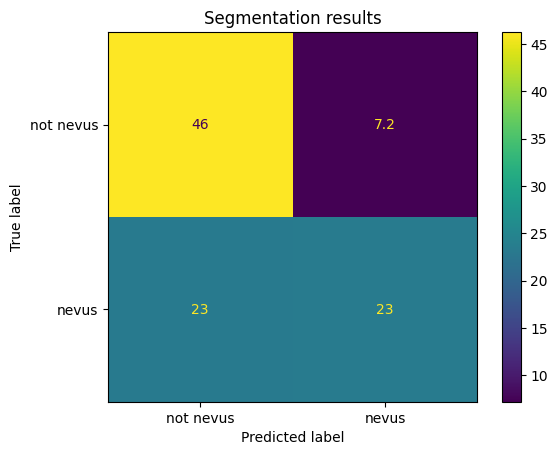

In [ ]:
# Confusion matrix
result_b = result>150
con_mat  = confusion_matrix(result_b.flatten(),final_result_out.flatten()) # tn, fp, fn, tp

disp = ConfusionMatrixDisplay(con_mat/np.sum(con_mat)*100,
                                              display_labels=['not nevus','nevus'])
disp.plot()
disp.ax_.set_title('Segmentation results')

F1_score = con_mat[1,1]/(con_mat[1,1]+1/2*(con_mat[1,0]+con_mat[0,1]))
precision = con_mat[1,1]/(con_mat[1,1]+con_mat[0,1]) # tp/(tp+fp)
recall = con_mat[1,1]/(con_mat[1,1]+con_mat[1,0])# tp/(tp+fn)

# precision - correct white ones / white ones predicted
# recall - correct white ones / all the white ones

print("F1 score: ", F1_score*100)
print("precision : ", precision*100)
print("recall : ", recall*100)